In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## Comparison of Stan model to kaggle data analysis:

### Read in Data:

In [149]:
data = pd.read_csv("CarPrice_Assignment.csv")
data.head()

car_ID  symboling                   CarName fueltype aspiration doornumber  \
0       1          3        alfa-romero giulia      gas        std        two   
1       2          3       alfa-romero stelvio      gas        std        two   
2       3          1  alfa-romero Quadrifoglio      gas        std        two   
3       4          2               audi 100 ls      gas        std       four   
4       5          2                audi 100ls      gas        std       four   

       carbody drivewheel enginelocation  wheelbase  ...  enginesize  \
0  convertible        rwd          front       88.6  ...         130   
1  convertible        rwd          front       88.6  ...         130   
2    hatchback        rwd          front       94.5  ...         152   
3        sedan        fwd          front       99.8  ...         109   
4        sedan        4wd          front       99.4  ...         136   

   fuelsystem  boreratio  stroke compressionratio horsepower  peakrpm citympg  \
0        mpfi       3.47    2.68              9.0        111     5000      21   
1        mpfi       3.47    2.68              9.0        111     5000      21   
2        mpfi       2.68    3.47              9.0        154     5000      19   
3        mpfi       3.19    3.40             10.0        102     5500      24   
4        mpfi       3.19    3.40              8.0        115     5500      18   

   highwaympg    price  
0          27  13495.0  
1          27  16500.0  
2          26  16500.0  
3          30  13950.0  
4          22  17450.0  

[5 rows x 26 columns]

### Data Preprocessing (same as kaggle analysis):

In [150]:
# Extract brand and model from CarName
data['brand'] = data['CarName'].apply(lambda x: x.split(' ')[0])
data['model'] = data['CarName'].apply(lambda x: ' '.join(x.split(' ')[1:]))

# Define categorical and numerical columns
categorical_columns = ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
                       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'brand', 'model']
numerical_columns = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
                     'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
                     'peakrpm', 'citympg', 'highwaympg']

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Feature engineering
data['power_to_weight_ratio'] = data['horsepower'] / data['curbweight']
for column in numerical_columns:
    data[f'{column}_squared'] = data[column] ** 2
data['log_enginesize'] = np.log(data['enginesize'] + 1)

# Feature scaling
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data.head()

car_ID  symboling                   CarName  fueltype  aspiration  \
0       1          3        alfa-romero giulia         1           0   
1       2          3       alfa-romero stelvio         1           0   
2       3          1  alfa-romero Quadrifoglio         1           0   
3       4          2               audi 100 ls         1           0   
4       5          2                audi 100ls         1           0   

   doornumber  carbody  drivewheel  enginelocation  wheelbase  ...  \
0           1        0           2               0  -1.690772  ...   
1           1        0           2               0  -1.690772  ...   
2           1        2           2               0  -0.708596  ...   
3           0        3           1               0   0.173698  ...   
4           0        3           0               0   0.107110  ...   

   curbweight_squared  enginesize_squared  boreratio_squared  stroke_squared  \
0             6492304               16900            12.0409          7.1824   
1             6492304               16900            12.0409          7.1824   
2             7969329               23104             7.1824         12.0409   
3             5461569               11881            10.1761         11.5600   
4             7974976               18496            10.1761         11.5600   

   compressionratio_squared  horsepower_squared  peakrpm_squared  \
0                      81.0               12321         25000000   
1                      81.0               12321         25000000   
2                      81.0               23716         25000000   
3                     100.0               10404         30250000   
4                      64.0               13225         30250000   

   citympg_squared  highwaympg_squared  log_enginesize  
0              441                 729        4.875197  
1              441                 729        4.875197  
2              361                 676        5.030438  
3              576                 900        4.700480  
4              324                 484        4.919981  

[5 rows x 43 columns]

<Axes: xlabel='price', ylabel='Count'>

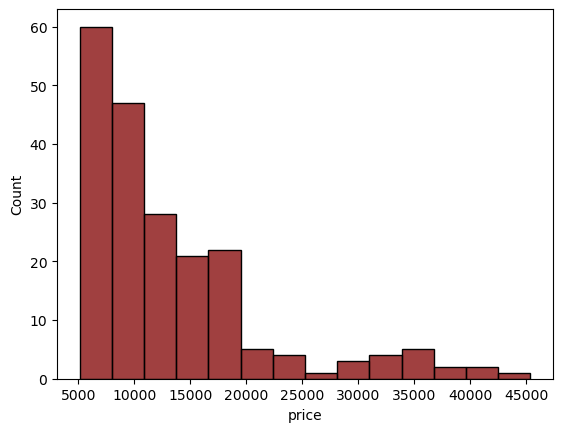

In [151]:
# Inspect the price data
sns.histplot(data.price, color='maroon')

<Axes: xlabel='price', ylabel='Count'>

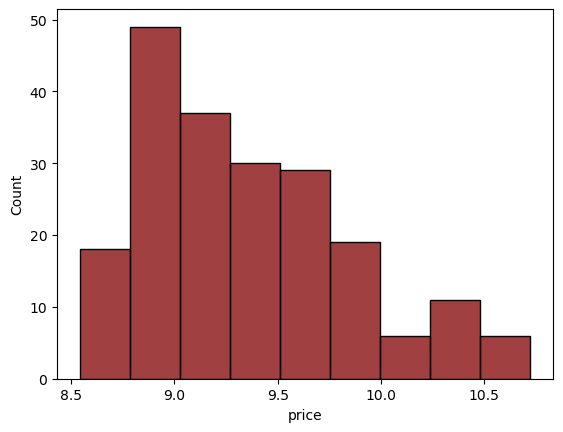

In [152]:
# Price data is not normally distribited, so do log transform
log_price = np.log(data.price)
sns.histplot(log_price, color='maroon')

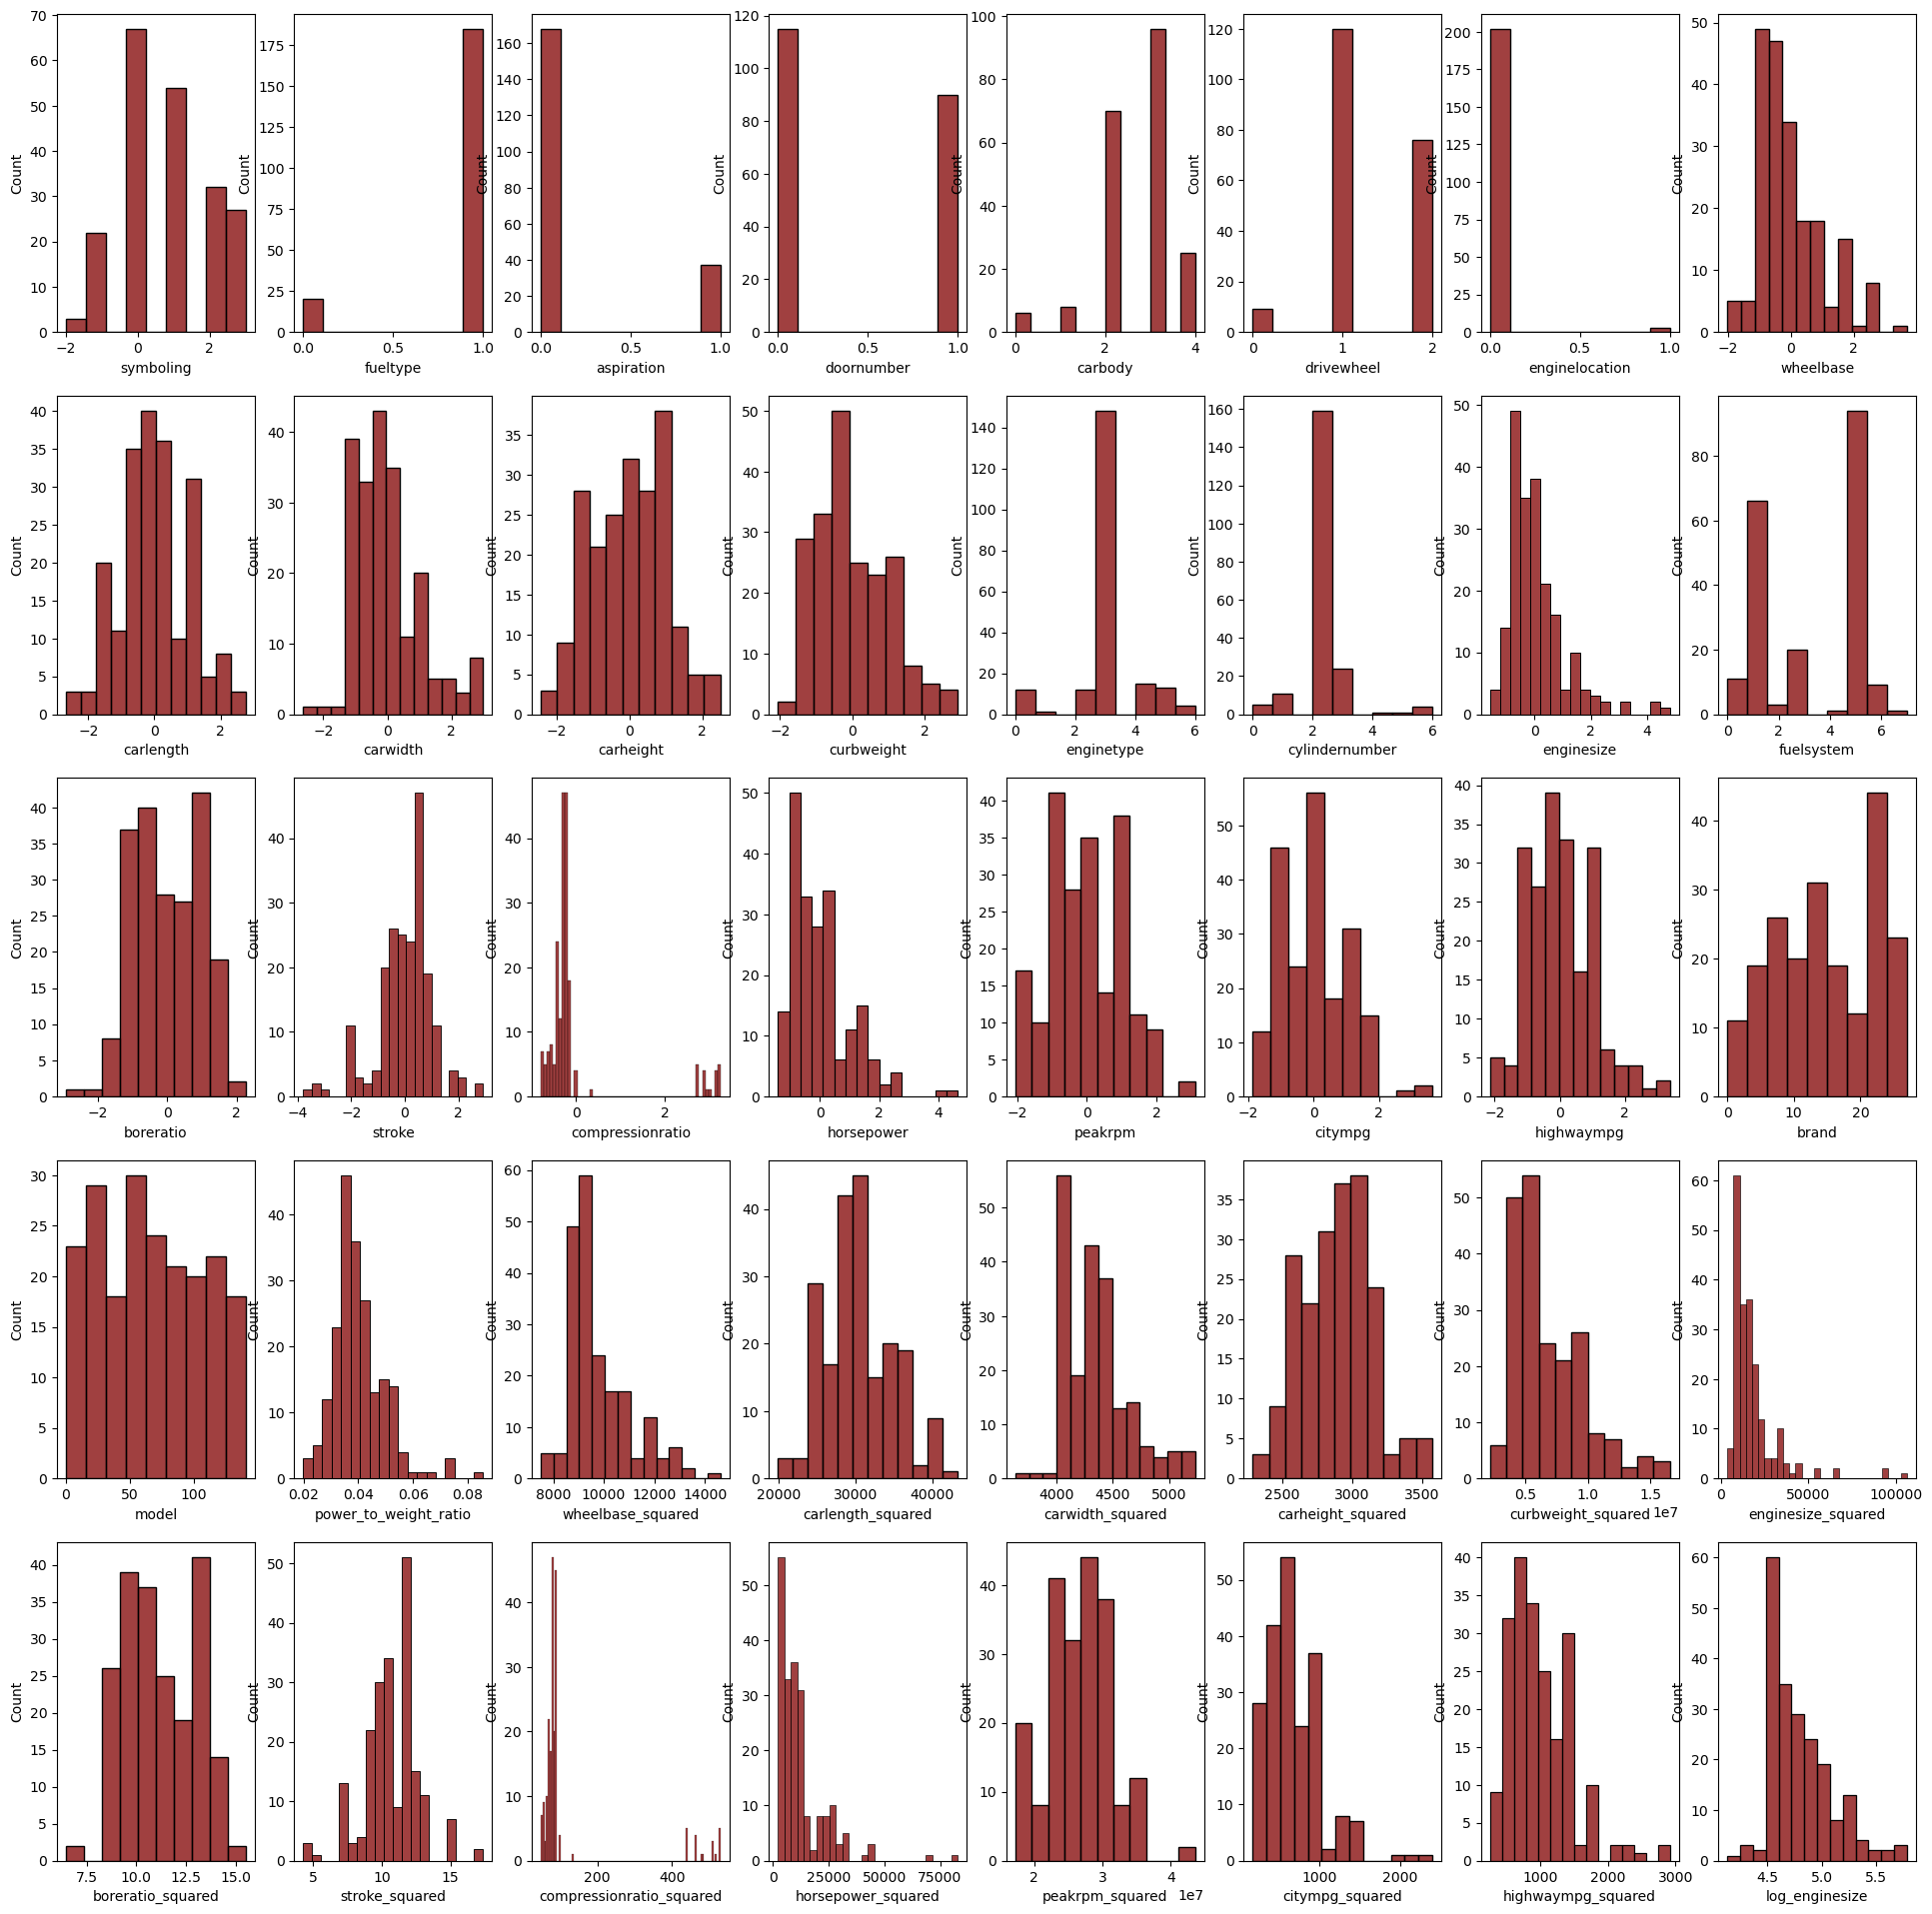

In [153]:
# Inspect histplots of all features
_, ax = plt.subplots(5, 8, figsize=(24, 24))
ax = ax.flatten()
cols = np.array(data.columns)
cols = cols[cols != 'car_ID']
cols = cols[cols != 'CarName']
cols = cols[cols != 'price']
for col, a in zip(cols, ax):
    sns.histplot(data[col], ax=a, color='maroon')

In [154]:
# Use all possible features (don't use squared or logged features that kaggle analysis uses, this makes model not converge)
use_data = data.iloc[:, :29].drop(['car_ID', 'CarName', 'price'], axis=1)
use_data.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'brand', 'model',
       'power_to_weight_ratio'],
      dtype='object')

In [155]:
# Split data into train and test set
X = np.array(use_data)
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Stan Model:

In [156]:
program_code = """
data {
    int<lower=1> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] y;
    int<lower=1> N_test;
    matrix[N_test, K] X_test;
    real mu1;
    real mu2;
    real mu3;
    real sd1;
    real sd2;
    real sd3;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ normal(mu1, sd1);
    alpha ~ normal(mu2, sd2);
    beta ~ normal(mu2, sd3);

    // Likelihood
    y ~ normal(alpha + X * beta, sigma);
}

generated quantities {
    array[N] real gen_y;
    gen_y = normal_rng(alpha + X * beta, sigma);

    array[N_test] real pred_y;
    pred_y = normal_rng(alpha + X_test * beta, sigma);
}
"""

In [157]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test,
    'mu1': 0, #mu and sd are for testing different priors
    'mu2': 9.2,
    'mu3': 9.2,
    'sd1': 10,
    'sd2': 2,
    'sd3': 2
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  15% (1800/12000)
Sampling:  17% (2000/12000)
Sampling: 

In [158]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters       lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
draws                                                                         
0          -35.954118       0.982485    0.021150          7.0         255.0   
1          -35.779861       0.910023    0.021926          7.0         255.0   
2          -27.852992       0.902112    0.019326          8.0         255.0   
3          -29.293440       0.977479    0.019790          7.0         255.0   
4          -33.989608       0.665068    0.021150          7.0         127.0   

parameters  divergent__   energy__     sigma     alpha    beta.1  ...  \
draws                                                             ...   
0                   0.0  49.906445  0.148300  7.594796 -0.001514  ...   
1                   0.0  49.637057  0.163281  8.248563  0.004195  ...   
2                   0.0  41.468392  0.145637  7.753732 -0.016590  ...   
3                   0.0  41.364997  0.148531  8.671123 -0.007983  ...   
4                   0.0  53.039843  0.147630  7.633063 -0.005328  ...   

parameters  pred_y.32  pred_y.33  pred_y.34  pred_y.35  pred_y.36  pred_y.37  \
draws                                                                          
0            8.574415   8.924352   9.796142   9.152348  10.286988   9.289562   
1            8.695705   8.729179   9.755425   9.428221  10.006774   9.335389   
2            8.906320   8.904131   9.904519   9.122108  10.261903   9.408372   
3            8.867620   8.923073   9.468744   9.193112  10.410757   9.365006   
4            8.637592   8.865717   9.898511   8.992888  10.198011   9.531760   

parameters  pred_y.38  pred_y.39  pred_y.40  pred_y.41  
draws                                                   
0            9.136349   8.755568   9.236624   8.757716  
1            9.481861   8.879576   9.614643   9.157900  
2            9.399714   8.892332   9.419494   8.928167  
3            9.784249   8.993079   9.437889   8.965367  
4            9.490948   8.827255   9.480251   8.973537  

[5 rows x 240 columns]

In [159]:
regression_summary = az.summary(regression_fit)
regression_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma       0.154  0.010   0.136    0.171      0.000    0.000    7159.0   
alpha       7.959  0.377   7.290    8.709      0.006    0.004    3717.0   
beta[0]    -0.001  0.017  -0.032    0.032      0.000    0.000    6391.0   
beta[1]     1.281  0.394   0.540    2.003      0.007    0.005    3649.0   
beta[2]     0.082  0.054  -0.024    0.176      0.001    0.001    5749.0   
...           ...    ...     ...      ...        ...      ...       ...   
pred_y[36]  9.265  0.171   8.944    9.581      0.002    0.001    8280.0   
pred_y[37]  9.322  0.175   8.995    9.652      0.002    0.001    8251.0   
pred_y[38]  8.745  0.164   8.448    9.062      0.002    0.001    8005.0   
pred_y[39]  9.513  0.161   9.207    9.814      0.002    0.001    8000.0   
pred_y[40]  8.953  0.167   8.634    9.266      0.002    0.001    7729.0   

            ess_tail  r_hat  
sigma         5814.0    1.0  
alpha         4623.0    1.0  
beta[0]       5638.0    1.0  
beta[1]       4572.0    1.0  
beta[2]       6074.0    1.0  
...              ...    ...  
pred_y[36]    7929.0    1.0  
pred_y[37]    7792.0    1.0  
pred_y[38]    7859.0    1.0  
pred_y[39]    7674.0    1.0  
pred_y[40]    7926.0    1.0  

[233 rows x 9 columns]

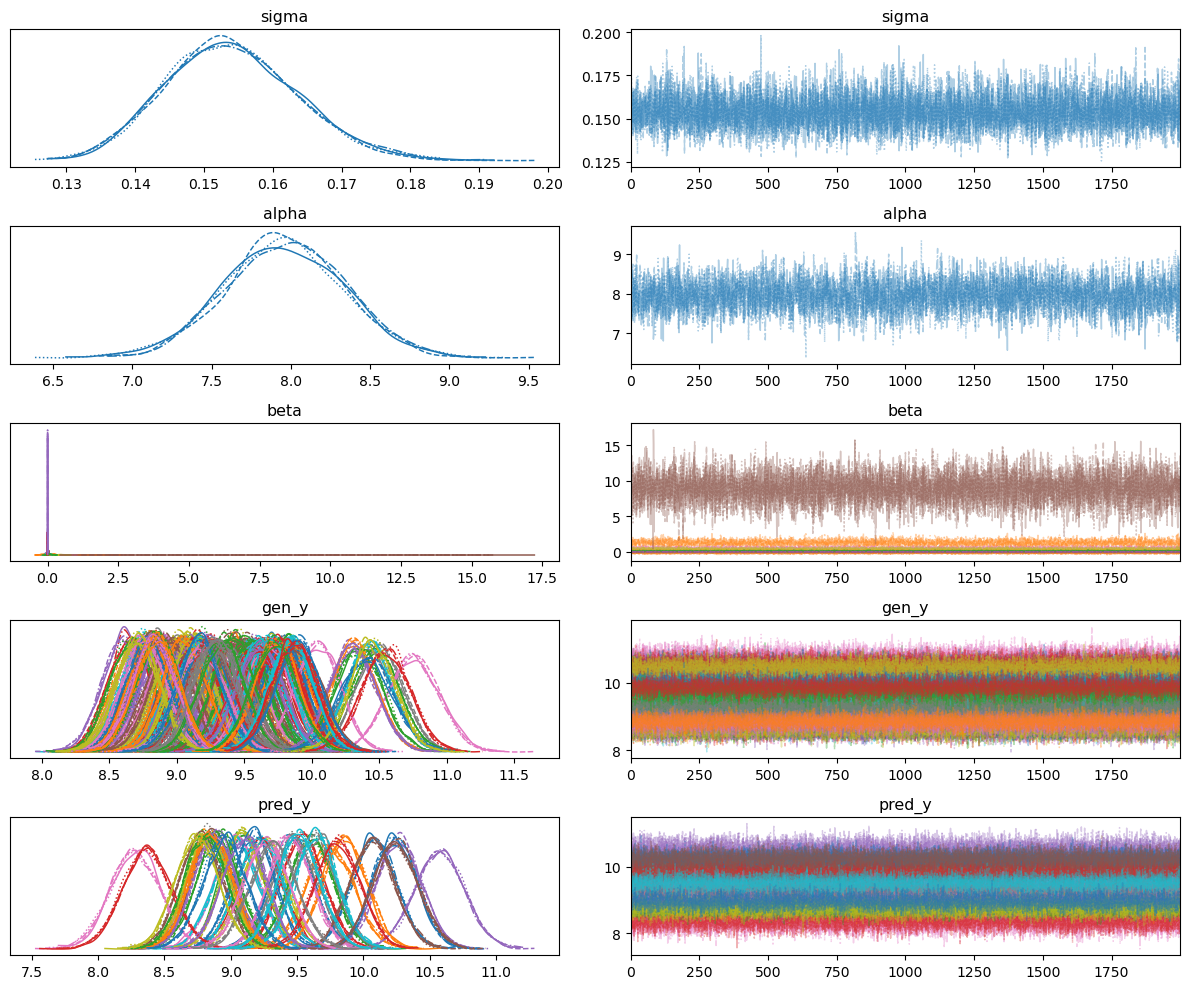

In [160]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

<Axes: ylabel='Density'>

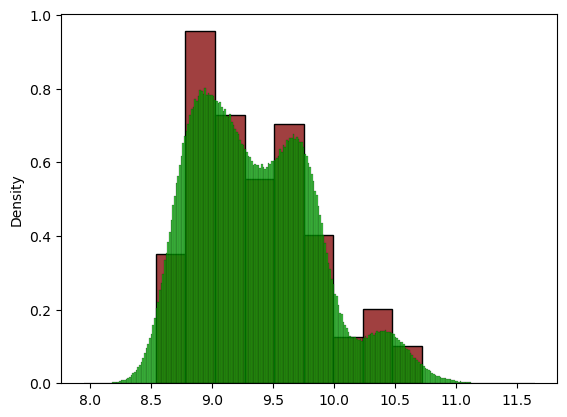

In [161]:
# Marginal Check (Generative)
sns.histplot(y_train, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 35:199].values.flatten(), stat='density', color='#00AA00')

<Axes: ylabel='Density'>

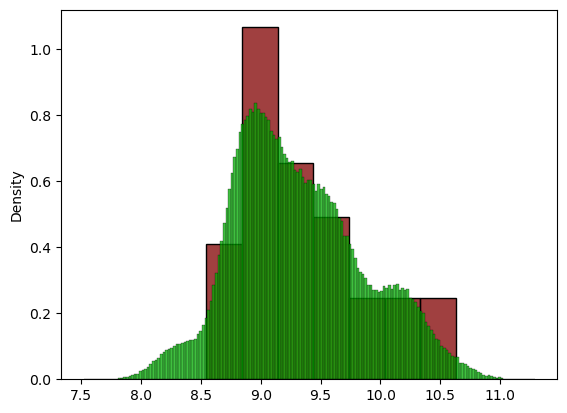

In [162]:
# Marginal Check (Predictive)
sns.histplot(y_test, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 199:].values.flatten(), stat='density', color='#00AA00')

In [163]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.1399543305189643
R2-Score: 0.9209857712112461


In [164]:
# Predictive Performance
preds = regression_fit.__getitem__('pred_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_test)**2))
r2 = r2_score(y_test, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.18430297803007506
R2-Score: 0.8748086800750547


In [165]:
# Betas (check which have the most influence)
betas = regression_fit.__getitem__('beta')
betas_mean = betas.mean(axis=1)
betas_mean

array([-1.16581680e-03,  1.28120037e+00,  8.16780970e-02, -6.73556944e-02,
       -6.62512100e-02,  3.59397759e-02,  5.24205491e-01,  2.64985697e-02,
        1.83703346e-02,  5.45974932e-02,  3.17277751e-02,  2.31339433e-01,
        1.28749833e-02, -1.52735996e-02,  3.28531983e-02,  3.39833989e-02,
        8.11225886e-03, -1.73463897e-02,  4.37240515e-01, -5.67037292e-02,
        1.99922007e-02, -1.79293862e-01,  8.92362803e-02, -9.85119963e-03,
        4.99244248e-04,  8.93869580e+00])

## Removing Features (Test 1):

In [166]:
# Get indices of features with value >= 1e-2 from previous test
indices = np.where(betas_mean >= 1e-2)[0]
indices

array([ 1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 18, 20, 22, 25])

In [167]:
# Use all these features for next test
use_data = use_data.iloc[:, indices]
use_data.columns

Index(['fueltype', 'aspiration', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'enginesize', 'fuelsystem', 'compressionratio', 'peakrpm', 'highwaympg',
       'power_to_weight_ratio'],
      dtype='object')

In [168]:
# Split data into train and test set
X = np.array(use_data)
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [169]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test,
    'mu1': 0, #mu and sd are for testing different priors
    'mu2': 9.2,
    'mu3': 9.2,
    'sd1': 10,
    'sd2': 2,
    'sd3': 2
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   1% (103/12000)
Sampling:   3% (302/12000)
Sampling:   4% (501/12000)
Sampling:   7% (800/12000)
Sampling:   8% (1000/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  15% (1800/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2200/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2700/12000)
Sampling:  25% (3000/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3400/12000)
Sampling:  47% (5600/12000)
Sampling:  65% (7800/12000)
Sa

In [170]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters       lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
draws                                                                         
0           46.977556       0.629514    0.029352          7.0         127.0   
1           52.137329       0.995664    0.027539          7.0         127.0   
2           53.258828       0.949780    0.028389          7.0         127.0   
3           53.439237       0.999201    0.026965          7.0         127.0   
4           46.686090       0.997234    0.029352          7.0         127.0   

parameters  divergent__   energy__     sigma     alpha    beta.1  ...  \
draws                                                             ...   
0                   0.0 -38.004238  0.177791  7.966461  0.721404  ...   
1                   0.0 -42.628323  0.156906  8.111688  0.842018  ...   
2                   0.0 -41.119015  0.154773  8.070993  0.782423  ...   
3                   0.0 -42.410447  0.173948  8.516044  0.495154  ...   
4                   0.0 -41.484409  0.181228  7.943360  0.791108  ...   

parameters  pred_y.32  pred_y.33  pred_y.34  pred_y.35  pred_y.36  pred_y.37  \
draws                                                                          
0            8.746588   8.712385  10.162018   9.173889   9.967521   9.299329   
1            8.888929   8.958872   9.770659   9.021247  10.085265   9.176023   
2            8.825464   8.786984   9.885201   8.892332  10.241202   9.029772   
3            8.649598   8.931800  10.010781   8.921683   9.884866   9.001654   
4            8.584016   8.895507   9.878658   9.302407  10.210068   9.395269   

parameters  pred_y.38  pred_y.39  pred_y.40  pred_y.41  
draws                                                   
0            9.339536   8.899006   9.218440   8.922591  
1            9.467188   8.778076   9.376029   8.915339  
2            9.584003   8.692586   9.530737   9.042204  
3            9.211614   8.818661   9.740215   9.125803  
4            9.535485   8.986838   9.474283   9.125670  

[5 rows x 230 columns]

In [171]:
regression_summary = az.summary(regression_fit)
regression_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma       0.172  0.010   0.153    0.192      0.000    0.000    8370.0   
alpha       8.269  0.332   7.617    8.860      0.006    0.004    3252.0   
beta[0]     0.622  0.361  -0.067    1.289      0.007    0.005    3036.0   
beta[1]    -0.007  0.053  -0.109    0.092      0.001    0.001    5390.0   
beta[2]     0.061  0.036  -0.008    0.127      0.000    0.000    6179.0   
...           ...    ...     ...      ...        ...      ...       ...   
pred_y[36]  9.207  0.183   8.869    9.550      0.002    0.001    8328.0   
pred_y[37]  9.377  0.189   9.035    9.732      0.002    0.001    8284.0   
pred_y[38]  8.730  0.179   8.402    9.077      0.002    0.001    7746.0   
pred_y[39]  9.556  0.182   9.226    9.902      0.002    0.001    7786.0   
pred_y[40]  9.080  0.176   8.762    9.421      0.002    0.001    7743.0   

            ess_tail  r_hat  
sigma         6132.0    1.0  
alpha         4707.0    1.0  
beta[0]       4434.0    1.0  
beta[1]       6130.0    1.0  
beta[2]       5802.0    1.0  
...              ...    ...  
pred_y[36]    7937.0    1.0  
pred_y[37]    7971.0    1.0  
pred_y[38]    7973.0    1.0  
pred_y[39]    7209.0    1.0  
pred_y[40]    7847.0    1.0  

[223 rows x 9 columns]

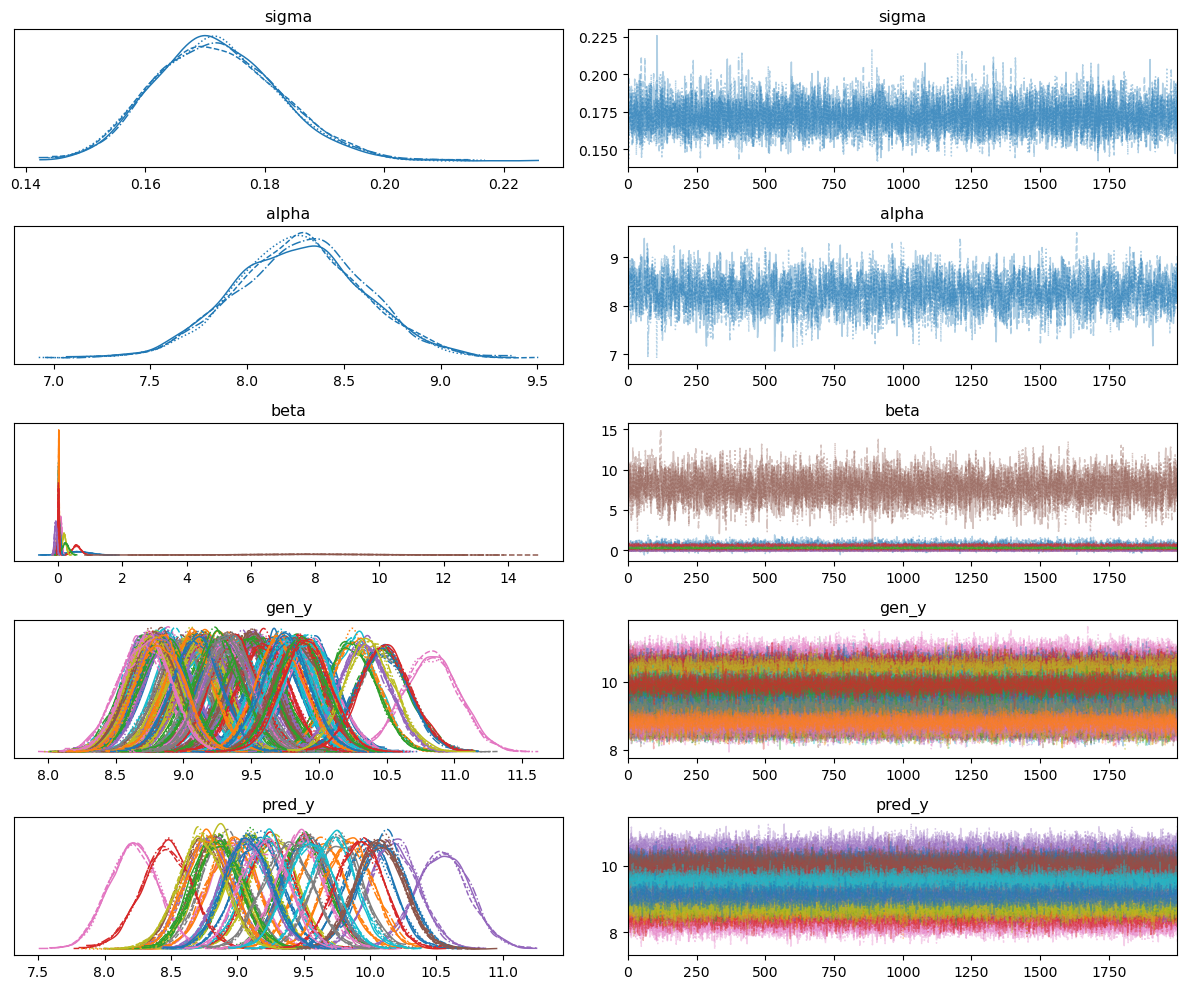

In [172]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

<Axes: ylabel='Density'>

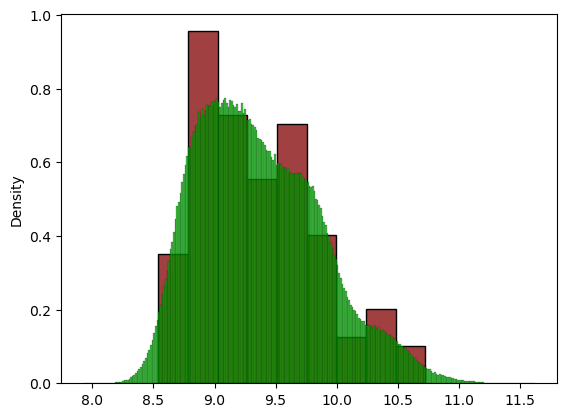

In [173]:
# Marginal Check (Generative)
sns.histplot(y_train, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 35:199].values.flatten(), stat='density', color='#00AA00')

<Axes: ylabel='Density'>

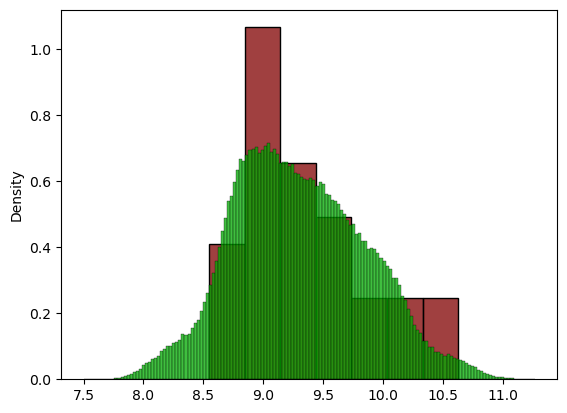

In [174]:
# Marginal Check (Predictive)
sns.histplot(y_test, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 199:].values.flatten(), stat='density', color='#00AA00')

In [175]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.16189660888415056
R2-Score: 0.894267590959777


In [176]:
# Predictive Performance
preds = regression_fit.__getitem__('pred_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_test)**2))
r2 = r2_score(y_test, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.1937322893182025
R2-Score: 0.8616709055631905


In [177]:
# Betas (check which have the most influence)
betas = regression_fit.__getitem__('beta')
betas_mean = betas.mean(axis=1)
betas_mean

array([ 6.22210487e-01, -7.16350099e-03,  6.11553891e-02,  5.76257878e-01,
       -6.10752096e-03,  3.49529926e-02,  8.64906215e-02,  1.13345325e-02,
        1.91118460e-01,  1.29328082e-02,  3.57371371e-02,  2.31779448e-02,
        2.33108426e-01,  1.31455460e-02, -7.22233528e-02,  7.82996727e+00])

## Removing Features (Test 2):

In [178]:
# Get indices of features with value >= 1e-1 from previous test
indices = np.where(np.abs(betas_mean) >= 1e-1)[0]
indices

array([ 0,  3,  8, 12, 15])

In [179]:
# Use all these features for next test
use_data = use_data.iloc[:, indices]
use_data.columns

Index(['fueltype', 'enginelocation', 'curbweight', 'compressionratio',
       'power_to_weight_ratio'],
      dtype='object')

In [180]:
# Split data into train and test set
X = np.array(use_data)
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [181]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test,
    'mu1': 0, #mu and sd are for testing different priors
    'mu2': 9.2,
    'mu3': 9.2,
    'sd1': 10,
    'sd2': 2,
    'sd3': 2
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (300/12000)
Sampling:   4% (500/12000)
Sampling:   7% (800/12000)
Sampling:  10% (1200/12000)
Sampling:  12% (1500/12000)
Sampling:  15% (1800/12000)
Sampling:  19% (2300/12000)
Sampling:  22% (2700/12000)
Sampling:  43% (5200/12000)
Sampling:  64% (7700/12000)
Sampling:  82% (9900/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradi

In [182]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters        lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
draws                                                                          
0           154.516313       0.999859    0.035224          6.0         127.0   
1           147.737163       0.995998    0.040703          6.0          63.0   
2           156.299733       0.905769    0.037210          5.0          47.0   
3           154.308815       0.928749    0.043824          7.0         127.0   
4           155.613446       0.854571    0.035224          7.0         127.0   

parameters  divergent__    energy__     sigma     alpha    beta.1  ...  \
draws                                                              ...   
0                   0.0 -151.885766  0.187011  8.117600  0.860557  ...   
1                   0.0 -144.935567  0.153286  7.826730  1.257222  ...   
2                   0.0 -153.448802  0.186002  8.287113  0.711111  ...   
3                   0.0 -149.762983  0.194620  8.193166  0.757937  ...   
4                   0.0 -151.409590  0.184529  8.506367  0.498553  ...   

parameters  pred_y.32  pred_y.33  pred_y.34  pred_y.35  pred_y.36  pred_y.37  \
draws                                                                          
0            8.900346   8.944780   9.458818   9.133160  10.098948   9.113797   
1            8.816886   8.968632   9.787236   8.781740  10.114302   9.268079   
2            8.851962   8.823303  10.081893   9.122690   9.970350   9.216390   
3            8.979604   9.013440   9.970057   8.630681  10.131690   8.994320   
4            8.640727   8.794192   9.821579   9.173960  10.226678   9.821466   

parameters  pred_y.38  pred_y.39  pred_y.40  pred_y.41  
draws                                                   
0            9.275182   8.540721   9.348148   8.828798  
1            9.526029   8.513626   9.796483   9.156538  
2            9.142085   9.056746   9.639208   9.094529  
3            9.077222   9.114171   9.567575   9.047209  
4            9.263571   8.519568   9.701313   8.921182  

[5 rows x 219 columns]

In [183]:
regression_summary = az.summary(regression_fit)
regression_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma       0.186  0.010   0.167    0.206      0.000    0.000    5529.0   
alpha       8.270  0.273   7.764    8.792      0.005    0.004    2611.0   
beta[0]     0.733  0.299   0.172    1.287      0.006    0.004    2600.0   
beta[1]     0.570  0.117   0.341    0.782      0.002    0.001    4611.0   
beta[2]     0.418  0.017   0.385    0.448      0.000    0.000    4585.0   
...           ...    ...     ...      ...        ...      ...       ...   
pred_y[36]  9.273  0.189   8.913    9.624      0.002    0.002    7149.0   
pred_y[37]  9.252  0.189   8.893    9.597      0.002    0.002    7790.0   
pred_y[38]  8.825  0.190   8.462    9.166      0.002    0.002    7689.0   
pred_y[39]  9.617  0.190   9.260    9.974      0.002    0.002    7803.0   
pred_y[40]  9.086  0.187   8.741    9.444      0.002    0.002    7561.0   

            ess_tail  r_hat  
sigma         4302.0    1.0  
alpha         3434.0    1.0  
beta[0]       3356.0    1.0  
beta[1]       4458.0    1.0  
beta[2]       4774.0    1.0  
...              ...    ...  
pred_y[36]    7651.0    1.0  
pred_y[37]    7885.0    1.0  
pred_y[38]    7640.0    1.0  
pred_y[39]    7519.0    1.0  
pred_y[40]    7998.0    1.0  

[212 rows x 9 columns]

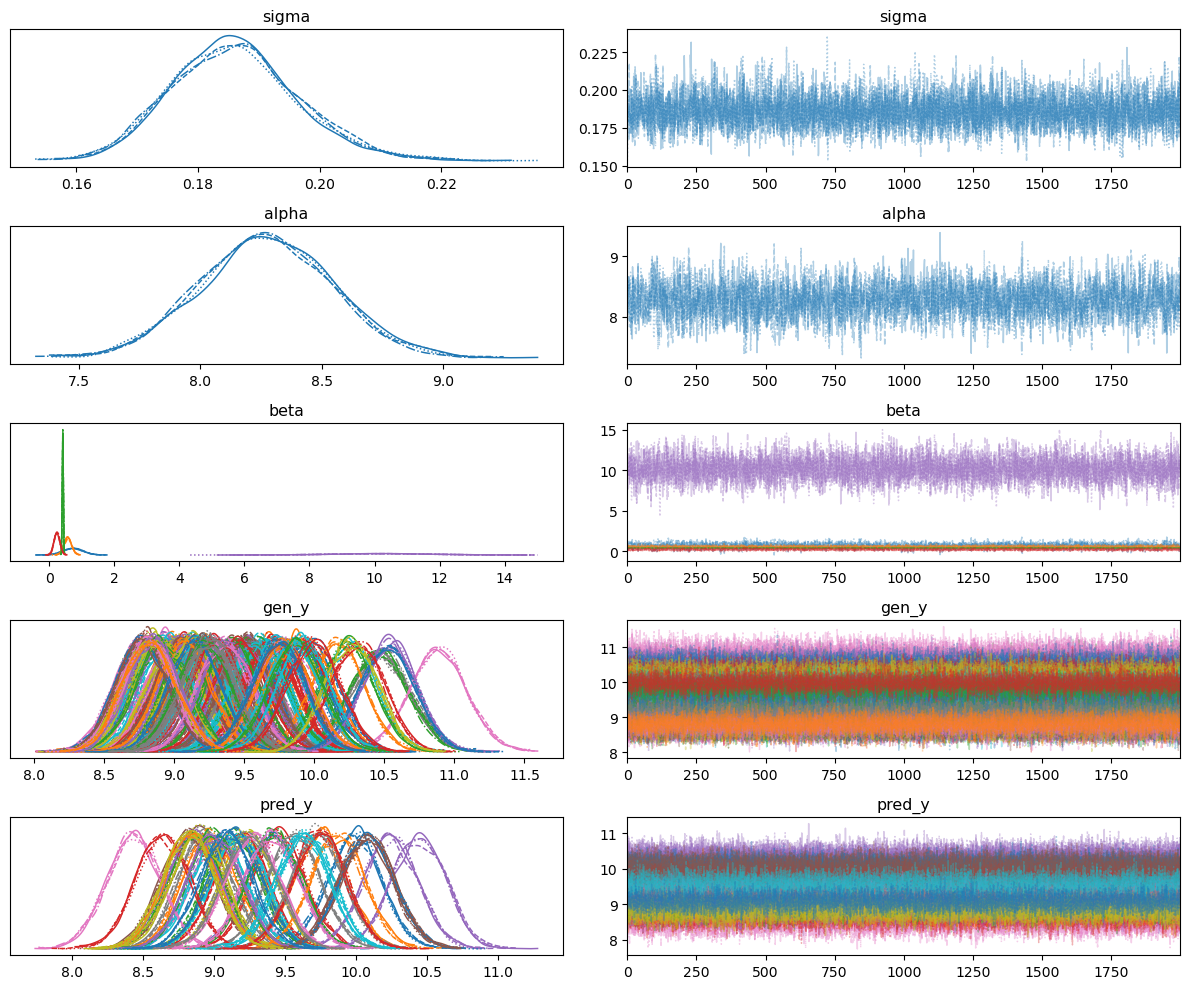

In [184]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

<Axes: ylabel='Density'>

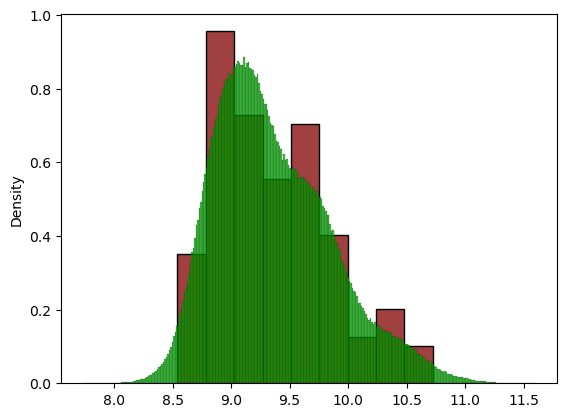

In [185]:
# Marginal Check (Generative)
sns.histplot(y_train, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 35:199].values.flatten(), stat='density', color='#00AA00')

<Axes: ylabel='Density'>

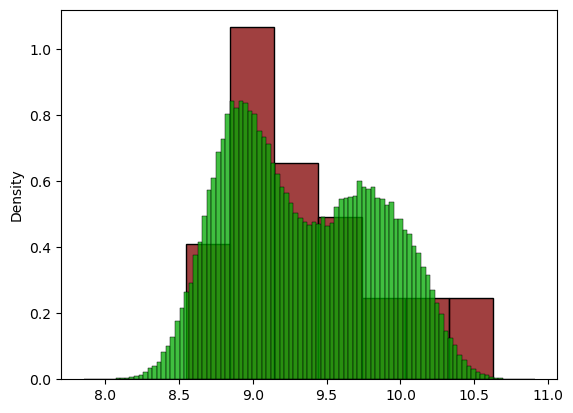

In [186]:
# Marginal Check (Predictive)
sns.histplot(y_test, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 199:].values.flatten(), stat='density', color='#00AA00')

In [187]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.18193179248387412
R2-Score: 0.8664789250201166


In [188]:
# Predictive Performance
preds = regression_fit.__getitem__('pred_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_test)**2))
r2 = r2_score(y_test, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.17560078558797754
R2-Score: 0.8863518365858813


In [189]:
# Betas (check which have the most influence)
betas = regression_fit.__getitem__('beta')
betas_mean = betas.mean(axis=1)
betas_mean

array([ 0.73299318,  0.56977651,  0.41776257,  0.23739787, 10.18729826])

## Changing Priors (Test):

### Altered Linear Regression Stan Model:

In [190]:
program_code = """
data {
    int<lower=1> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] y;
    int<lower=1> N_test;
    matrix[N_test, K] X_test;
    real mu1;
    real mu2;
    real mu3;
    real sd1;
    real sd2;
    real sd3;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ inv_gamma(mu1, sd1); //use inverse gamma now
    alpha ~ normal(mu2, sd2);
    beta ~ normal(mu2, sd3);

    // Likelihood
    y ~ normal(alpha + X * beta, sigma);
}

generated quantities {
    array[N] real gen_y;
    gen_y = normal_rng(alpha + X * beta, sigma);

    array[N_test] real pred_y;
    pred_y = normal_rng(alpha + X_test * beta, sigma);
}
"""

In [191]:
# Use same data as previous test because it had best predictive performance
use_data.columns

Index(['fueltype', 'enginelocation', 'curbweight', 'compressionratio',
       'power_to_weight_ratio'],
      dtype='object')

In [192]:
# Split data into train and test set
X = np.array(use_data)
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [194]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test,
    'mu1': 1, #change mu and sd
    'mu2': 9.4,
    'mu3': 9.4,
    'sd1': 1,
    'sd2': 3,
    'sd3': 3
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   2% (300/12000)
Sampling:   4% (500/12000)
Sampling:   7% (800/12000)
Sampling:   9% (1100/12000)
Sampling:  12% (1400/12000)
Sampling:  15% (1800/12000)
Sampling:  18% (2100/12000)
Sampling:  21% (2500/12000)
Sampling:  24% (2900/12000)
Sampling:  44% (5300/12000)
Sampling:  64% (7700/12000)
Sampling:  82% (9900/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectat

In [195]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters        lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
draws                                                                          
0           174.055017       0.927992    0.034764          7.0         127.0   
1           175.297472       0.930056    0.038745          6.0          95.0   
2           173.914304       0.934095    0.034564          7.0         127.0   
3           172.014035       0.998632    0.034964          6.0          63.0   
4           174.370526       0.914967    0.034764          6.0         127.0   

parameters  divergent__    energy__     sigma     alpha    beta.1  ...  \
draws                                                              ...   
0                   0.0 -171.580719  0.176243  8.266401  0.778010  ...   
1                   0.0 -170.453377  0.187738  8.273073  0.631129  ...   
2                   0.0 -172.715529  0.179910  8.682548  0.202456  ...   
3                   0.0 -169.420778  0.172297  7.995516  1.099000  ...   
4                   0.0 -170.086164  0.187400  8.360963  0.542080  ...   

parameters  pred_y.32  pred_y.33  pred_y.34  pred_y.35  pred_y.36  pred_y.37  \
draws                                                                          
0            8.863901   9.107962   9.547509   9.251389  10.002717   9.413855   
1            8.763595   9.164389  10.090860   8.926199   9.878181   9.065380   
2            8.783441   9.118965  10.121099   9.128223  10.161023   8.966625   
3            9.070066   9.016823   9.796954   8.820504  10.022928   9.197954   
4            9.146630   8.868880   9.629180   8.782057   9.905406   9.445376   

parameters  pred_y.38  pred_y.39  pred_y.40  pred_y.41  
draws                                                   
0            9.277700   9.032145   9.445600   9.430245  
1            9.184806   8.789837   9.751121   8.721179  
2            9.347026   8.994214   9.767460   9.298176  
3            9.394196   8.848037   9.704714   8.925377  
4            9.235756   8.576164   9.306079   8.885568  

[5 rows x 219 columns]

In [196]:
regression_summary = az.summary(regression_fit)
regression_summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma       0.188  0.011   0.168    0.208      0.000    0.000    5549.0   
alpha       8.372  0.277   7.846    8.879      0.005    0.004    2953.0   
beta[0]     0.594  0.307   0.005    1.154      0.006    0.004    2896.0   
beta[1]     0.552  0.122   0.321    0.775      0.002    0.001    4506.0   
beta[2]     0.413  0.017   0.381    0.446      0.000    0.000    5079.0   
...           ...    ...     ...      ...        ...      ...       ...   
pred_y[36]  9.286  0.189   8.934    9.642      0.002    0.002    7080.0   
pred_y[37]  9.252  0.188   8.893    9.605      0.002    0.002    7803.0   
pred_y[38]  8.823  0.189   8.448    9.157      0.002    0.001    7958.0   
pred_y[39]  9.633  0.189   9.276    9.984      0.002    0.001    7960.0   
pred_y[40]  9.086  0.188   8.735    9.437      0.002    0.001    8037.0   

            ess_tail  r_hat  
sigma         5021.0    1.0  
alpha         3632.0    1.0  
beta[0]       3614.0    1.0  
beta[1]       4509.0    1.0  
beta[2]       5158.0    1.0  
...              ...    ...  
pred_y[36]    8054.0    1.0  
pred_y[37]    7896.0    1.0  
pred_y[38]    7876.0    1.0  
pred_y[39]    7880.0    1.0  
pred_y[40]    7908.0    1.0  

[212 rows x 9 columns]

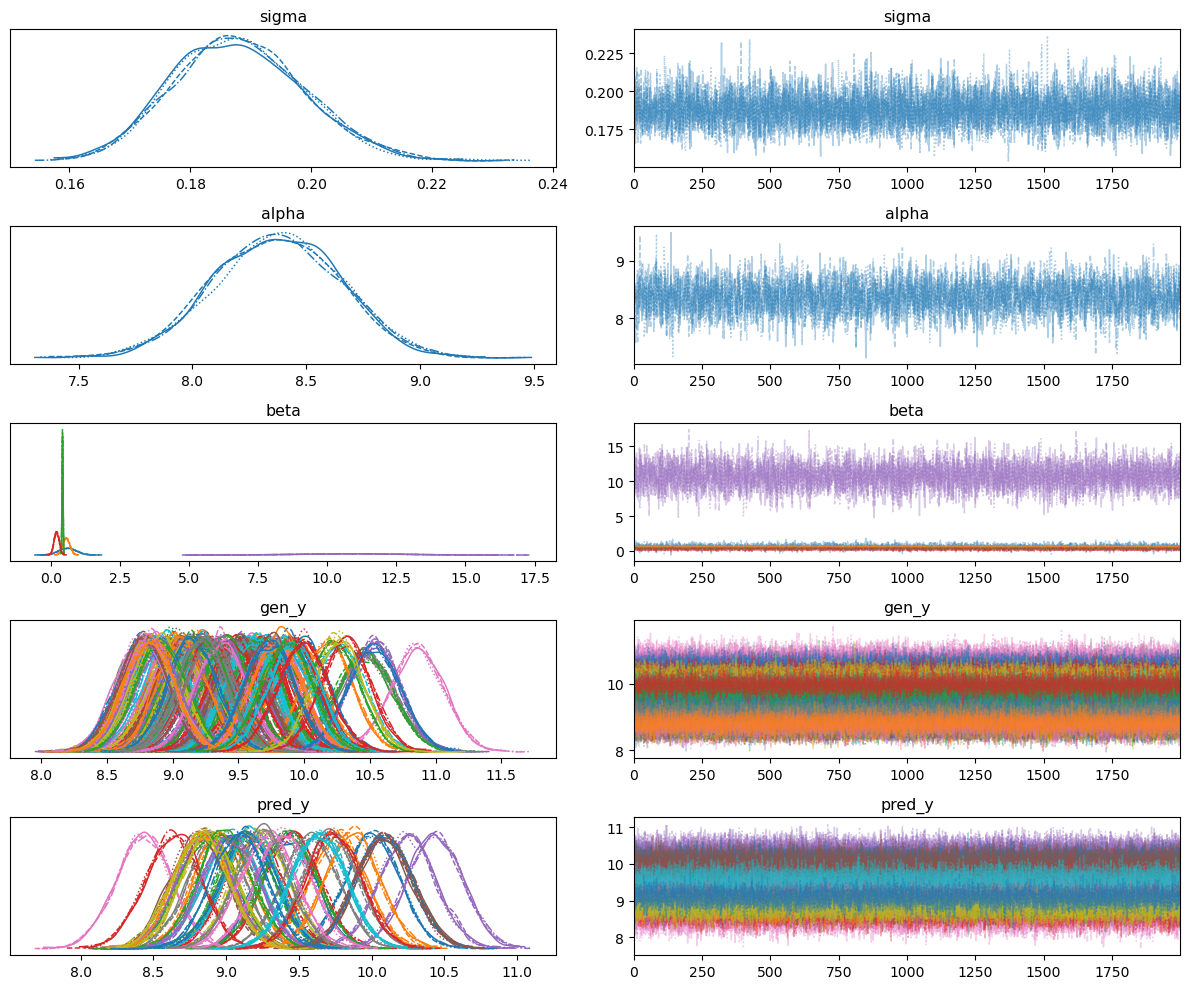

In [197]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

<Axes: ylabel='Density'>

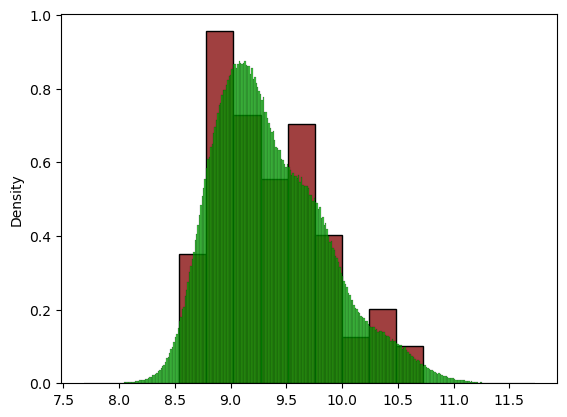

In [198]:
# Marginal Check (Generative)
sns.histplot(y_train, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 35:199].values.flatten(), stat='density', color='#00AA00')

<Axes: ylabel='Density'>

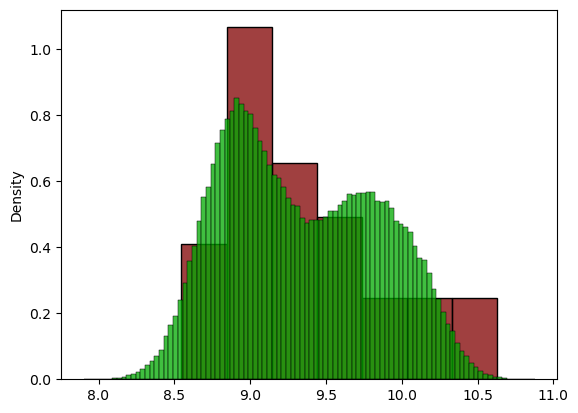

In [199]:
# Marginal Check (Predictive)
sns.histplot(y_test, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 199:].values.flatten(), stat='density', color='#00AA00')

In [200]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.1811634152365501
R2-Score: 0.8676043787288288


In [201]:
# Predictive Performance
preds = regression_fit.__getitem__('pred_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_test)**2))
r2 = r2_score(y_test, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.17384544903302093
R2-Score: 0.8886125747985993


In [202]:
# Betas (check which have the most influence)
betas = regression_fit.__getitem__('beta')
betas_mean = betas.mean(axis=1)
betas_mean

array([ 0.59415932,  0.55199826,  0.41290281,  0.19964268, 10.78368198])